In [1]:
from pystencils.session import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

sp.init_printing()

### Code Generation for the Heat Equation

The <a target="_blank" href="https://en.wikipedia.org/wiki/Heat_equation">heat equation</a> which is a simple partial differential equation describing the flow of heat through a homogenous medium. We can write it as
$$
    \frac{\partial u}{\partial t} = 
    \kappa \left( 
        \frac{\partial^2 u}{\partial x^2} +  
        \frac{\partial^2 u}{\partial y^2}
    \right)
$$
where $\kappa$ is the medium's diffusion coefficient and $u(x, y, t)$ is the unknown temperature distribution at the coordinate $(x,y)$ at time $t$.

To discretize this equation using pystencils, we first need to define all the fields and other symbols involved.

In [2]:
u, u_tmp = ps.fields("u, u_tmp: [2D]", layout='fzyx')
kappa = sp.Symbol("kappa")
dx = sp.Symbol("dx")
dt = sp.Symbol("dt")

We define the PDE using the pystencils building blocks for transient and spatial derivatives. The definition is implicitly equalled to zero. We use `ps.fd.transient` for a first derivative by time and `ps.fd.diff` to express the second derivatives. `ps.fd.diff` takes a field and a list of spatial dimensions in which the field should be differentiated.

In [3]:
heat_pde = ps.fd.transient(u) - kappa * ( ps.fd.diff( u, 0, 0 ) + ps.fd.diff( u, 1, 1 ) )
heat_pde

Next, the PDE will be discretized. We use the `Discretization2ndOrder` class to apply finite differences discretization to the spatial components, and explicit euler discretization to the transient components. 

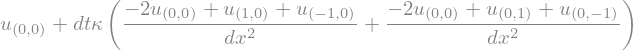

In [4]:
discretize = ps.fd.Discretization2ndOrder(dx=dx, dt=dt)
heat_pde_discretized = discretize(heat_pde)
heat_pde_discretized

It occurs to us that the right-hand summand can be simplified.

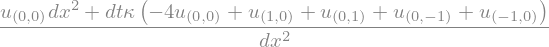

In [5]:
heat_pde_discretized.simplify()

While combining the two fractions on the right as desired, it also put everything above a common denominator. If we generated the kernel from this, we'd be redundantly multiplying $u_{(0,0)}$ by $dx^2$. Let's try something else. Instead of applying `simplify` to the entire equation, we could apply it only to the second summand.

The outermost operation of `heat_pde_discretized` is a $+$, so `heat_pde_discretized` is an instance of `sp.Sum`. We take it apart by accessing its arguments, simplify the right hand summand, and put it back together again.

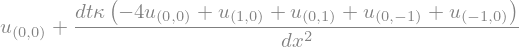

In [6]:
heat_pde_discretized =  heat_pde_discretized.args[1] + heat_pde_discretized.args[0].simplify()
heat_pde_discretized

That looks a lot better! There is nothing left to simplify. The right-hand summand still contains a division by $dx^2$, though. Due to their inefficiency, floating-point divisions should be replaced by multiplication with their reciprocals. Before we can eliminate the division, we need to wrap the equation inside an `AssignmentCollection`. On this collection we can apply `add_subexpressions_for_divisions` to replace the division by a factor $\xi_1 = \frac{1}{dx^2}$ which in the kernel will be computed ahead of the loop.

In [7]:
@ps.kernel
def update():
    u_tmp.center @= heat_pde_discretized

ac = ps.AssignmentCollection(update)
ac = ps.simp.simplifications.add_subexpressions_for_divisions(ac)
ac

$$\xi_{0} \leftarrow \frac{1}{dx^{2}}$$
"$${{u_tmp}_{(0,0)}} \leftarrow {{u}_{(0,0)}} + dt \kappa \xi_{0} \left(- 4 {{u}_{(0,0)}} + {{u}_{(1,0)}} + {{u}_{(0,1)}} + {{u}_{(0,-1)}} + {{u}_{(-1,0)}}\right)$$"


Our numeric solver's symbolic representation is now complete! Next, we use pystencils to generate and compile a C implementation of our kernel. The code is generated as shown below, compiled into a shared library and then bound to `kernel_func`. All unbound sympy symbols (`dx`, `dt` and `kappa`) as well as the fields `u` and `u_tmp` are arguments to the generated kernel function. 

In [8]:
config = ps.CreateKernelConfig(cpu_openmp=4)
kernel_ast = ps.create_kernel(update, config=config)
kernel_func = kernel_ast.compile()

ps.show_code(kernel_ast)

FUNC_PREFIX void kernel(double * RESTRICT const _data_u, double * RESTRICT _data_u_tmp, int64_t const _size_u_0, int64_t const _size_u_1, int64_t const _stride_u_0, int64_t const _stride_u_1, int64_t const _stride_u_tmp_0, int64_t const _stride_u_tmp_1, double dt, double dx, double kappa)
{
   #pragma omp parallel num_threads(4)
   {
      #pragma omp for schedule(static)
      for (int64_t ctr_1 = 1; ctr_1 < _size_u_1 - 1; ctr_1 += 1)
      {
         double * RESTRICT _data_u_tmp_10 = _data_u_tmp + _stride_u_tmp_1*ctr_1;
         double * RESTRICT _data_u_10 = _data_u + _stride_u_1*ctr_1;
         double * RESTRICT _data_u_11 = _data_u + _stride_u_1*ctr_1 + _stride_u_1;
         double * RESTRICT _data_u_1m1 = _data_u + _stride_u_1*ctr_1 - _stride_u_1;
         for (int64_t ctr_0 = 1; ctr_0 < _size_u_0 - 1; ctr_0 += 1)
         {
            _data_u_tmp_10[_stride_u_tmp_0*ctr_0] = dt*kappa*(-4.0*_data_u_10[_stride_u_0*ctr_0] + _data_u_10[_stride_u_0*ctr_0 + _stride_u_0] + _data_u_10[_stride_u_0*ctr_0 - _stride_u_0] + _data_u_11[_stride_u_0*ctr_0] + _data_u_1m1[_stride_u_0*ctr_0])/(dx*dx) + _data_u_10[_stride_u_0*ctr_0];
         }
      }
   }
}

### Prototype Simulation

We can set up and run a simple simulation with the generated kernel right here. The first step is to set up the fields and simulation parameters.

In [9]:
domain_size = 1.0
cells = 25
delta_x = domain_size / cells

delta_t = 0.0001
kappa_v = 1.0

u = np.zeros((cells, cells))
u_tmp = np.zeros_like(u)

We also need the Dirichlet and Neumann Boundaries.

In [10]:
def f(x):
    return (1 + np.sin(2 * np.pi * x) * x**2)

def init_domain(domain, domain_tmp):
    domain.fill(0)
    domain_tmp.fill(0)
    domain[:,-1] = f( np.linspace(0, 1, domain.shape[0]) )
    domain_tmp[:,-1] = f( np.linspace(0, 1, domain_tmp.shape[0]) )
    return domain, domain_tmp

def neumann(domain):
    domain[0,:] = domain[1, :]
    domain[-1,:] = domain[-2,:]
    domain[:,0] = domain[:,1]
    return domain

After application of the Dirichlet boundary condition, this is our initial situation. In waLBerla, the domain edges would be ghost layers.

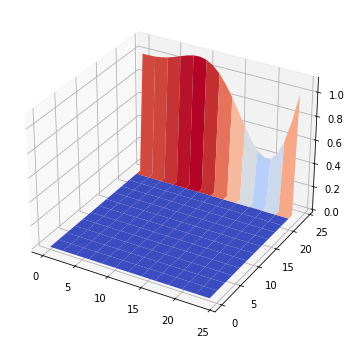

In [11]:
init_domain(u, u_tmp)

ps.plot.scalar_field_surface(u)

Finally, define the loop function.

In [12]:
def loop(steps = 5):
    global u, u_tmp
    for _ in range(steps):
        neumann(u)
        kernel_func(u=u, u_tmp=u_tmp, dx=delta_x, dt=delta_t, kappa=kappa_v)
        u, u_tmp = u_tmp, u

    return u

In [13]:
200 * 100 * delta_t

Not only can we run the kernel, we can even view the results as a video! This is a useful tool for debugging and testing the solver before introducing it into a larger application. We can view the simulation animated both as a colorful 2D plot or as a 3D surface plot.

The total time interval being simulated is two seconds (100 frames à 200 steps à 0.1 milliseconds).

In [14]:
init_domain(u, u_tmp)

anim = ps.plot.scalar_field_animation(lambda : loop(200), frames = 100, rescale = False)
result = ps.jupyter.display_as_html_video(anim)
result

In [15]:
init_domain(u, u_tmp)

anim = ps.plot.surface_plot_animation(lambda : loop(200), frames = 100)
result = ps.jupyter.display_as_html_video(anim)
result